In [1]:
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import wandb

from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from Dataset import ISBI
from utils import Random_processing
from Model.Vanila_UNet import VanilaUNet
from torchsummary import summary

random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

ds_train = ISBI(mode='train', transform=Random_processing())
ds_valid = ISBI(mode='valid', transform=Random_processing())

dl_train = DataLoader(ds_train, batch_size=1, shuffle=True)
dl_valid = DataLoader(ds_valid, batch_size=1 ,shuffle=False)

c:\Users\Master\miniconda3\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class config:
    Device = 'cuda' if torch.cuda.is_available() else 'cpu'
    Max_epoch = 20
    train_batch = 1
    valid_batch = 1
    model_name = 'Vanila_UNet'
    lr = 1e-3



In [ ]:
# wandb.login()
# WANDB_CONFIG = {'_wandb_kernel' : 'neuracort'}
# run = wandb.init(
#     project='ISBI 2012 Semantic segmentation',
#     config=WANDB_CONFIG
# )
# wandb.run.name = 'Vanila-UNet'

In [10]:
model = VanilaUNet(in_channels=3, out_channels=2).to(config.Device)
# summary(model, input_size=(3, 440, 440))

In [4]:
ce_loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = config.lr, momentum=0.99)

def loss_function(preds, targets):
    targets = targets.squeeze(0).long()
    loss = ce_loss(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()

    return loss, acc

class engine():
    def model_train(model, data, optimizer, loss_func):
        imgs, lbls = data['image'], data['label']
        model.train()

        imgs = imgs.to(config.Device)
        lbls = lbls.to(config.Device)

        preds = model(imgs)
        loss, acc = loss_func(preds, lbls)

        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        return loss.item(), acc.item()
    
    @torch.no_grad()
    def model_valid(model, data, loss_func):
        imgs, lbls = data['image'], data['label']
        model.eval()

        imgs = imgs.to(config.Device)
        lbls = lbls.to(config.Device)

        preds = model(imgs)
        loss, acc = loss_func(preds, lbls)

        return loss.item(), acc.item()

In [5]:
log_path = f'Model/{config.model_name}/log'
best_model_path = log_path + '/best_model'

# Check log & best model path
if os.path.exists(best_model_path):
    pass
else:
    os.makedirs(best_model_path)

# Set test image
test_sample = next(iter(dl_train))
test_img, test_lbl = test_sample['image'], test_sample['label']
view_img = test_img.squeeze().permute(1,2,0).numpy()*255.0
test_img = test_img.to(config.Device)
view_lbl = test_lbl.squeeze(0)
view_lbl = view_lbl.permute(1,2,0).numpy()

In [ ]:
# def run():
#     best_val_acc = 0.0
    
#     for epoch in range(config.Max_epoch):
#         print('-----------------------------')
#         print(f'    Epoch : {epoch}')
#         print('-----------------------------')


#         for _, data in tqdm(enumerate(dl_train), total=len(dl_train)):
#             train_loss, train_acc = engine.model_train(model, data, optimizer, loss_function)

#         for _, data in tqdm(enumerate(dl_valid), total=len(dl_valid)):
#             valid_loss, valid_acc = engine.model_valid(model, data, loss_function)

#         torch.save(model.state_dict(), os.path.join(log_path, f'epoch_{epoch}.pth'))

#         if valid_acc >= best_val_acc:
#             torch.save(model.state_dict(), os.path.join(best_model_path, 'best_model.pth'))

#         with torch.no_grad():
#             model.eval()
            
#             view_preds = model(test_img)
#             view_preds = torch.argmax(view_preds, dim=1)
#             view_pred = view_preds.permute(1,2,0).detach().cpu().numpy()

#         wandb.log(
#             {
#                 'epoch' : epoch,
#                 'train_loss' : train_loss,
#                 'train_acc' : train_acc,
#                 'valid_loss' : valid_loss,
#                 'valid_acc' : valid_acc,
#                 'Color Image' : [wandb.Image(view_img, caption='Color image')],
#                 'Ground Truth' : [wandb.Image(view_lbl, caption='Ground truth')],
#                 'Model prediction' : [wandb.Image(view_pred, caption='Model Prediction')]
#             }   
#         )
#         print()

# run()


In [11]:
best_state = torch.load(f'{best_model_path}/best_model.pth')

model.load_state_dict(best_state)

<All keys matched successfully>

In [28]:
view_preds = model(test_img)

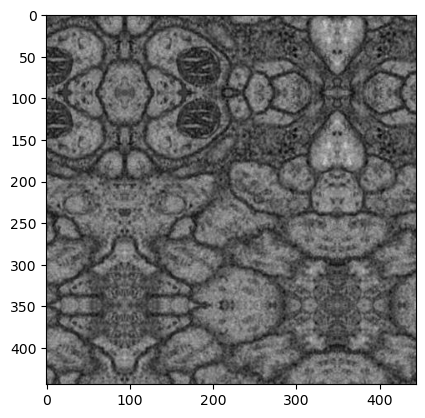

In [25]:
plt.imshow(view_img.astype(np.uint8))

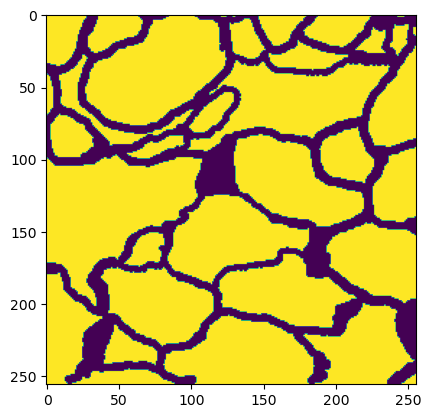

In [26]:
plt.imshow(view_lbl)

In [30]:
view_pred = torch.argmax(view_preds, dim = 1)
view_pred = view_pred.squeeze().detach().cpu().numpy()
view_pred.shape

(256, 256)

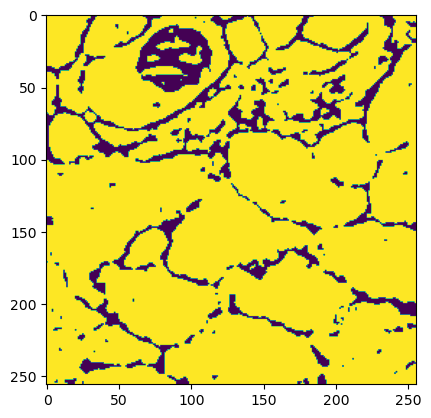

In [31]:
plt.imshow(view_pred)